<a href="https://colab.research.google.com/github/vicmancr/bigdataschool/blob/main/Part_01-Multi-center_cardiac_resonance_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this Notebook we are going to get familiarized with **_cardiac magnetic resonace imaging_**, also referred to as **cardiac MRI** or **CMR**.

The contents will cover:

    1. Some information about MRI
    2. How to load and visualize the data
    3. Steps to prepare the data for model training


---

## Magnetic resonance imaging

_Magnetic resonance imaging (MRI)_ is an image modality acquired in a big scan that uses strong magnetic fields to polarize hydrogen atoms (present in the water inside the body) and to detect the density of these atoms in different parts of the body. This image modality doesn't involve ionizing radiation, so there is no risk for the patient when taking multiple scans, and it is a non-invasive technique.

Here we have an illustration of the scan and several images that are acquired with these machines:

<table><tr>
<td>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Siemens_Magnetom_Aera_MRI_scanner.jpg/330px-Siemens_Magnetom_Aera_MRI_scanner.jpg" alt="Patient being positioned for MR study of the head and abdomen." width="200"/>
</td>
<td>
    <img src="https://upload.wikimedia.org/wikipedia/commons/0/03/T1-weighted-MRI.png" alt="T1-weighted 3D MRI axial section showing white matter and grey matter folds.." width="120"/>
</td>
<td>
    <img src="https://upload.wikimedia.org/wikipedia/commons/3/38/Mra1.jpg" alt="Magnetic resonance angiography." width="130"/>
</td>
<td>
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/25/Proton_density_MRI_of_a_grade_2_medial_meniscal_tear.jpg" alt="Proton density MRI in a coronal plane of the knee, showing a grade 2 medial meniscal tear." width="130"/>
</td>
<td>
    <img src="https://upload.wikimedia.org/wikipedia/commons/7/7f/LVSA.gif" alt="Short axis view on cardiovascular magnetic resonance imaging using a steady-state free precession imaging technique." width="130"/>
</td>
</tr></table>

Image source: [wikimedia.org](https://wikimedia.org).

## Cardiology

In cardiology, it is used to assess the heart function and to diagnose several pathologies, such as cardiomyopathy or heart failure. To do so, clinicians have to process the image by annotating the different anatomical regions (at different points in time) to extract the desired biomarkers, such as _Ejection Fraction_ (fraction of blood ejected by a heart cavitiy).

<img src="https://drive.google.com/uc?id=1oFIY0sPR1NSy8WF08wI_bqi3JqRu6DAw" alt="Sample manually annotated." width="200"/>

Image source: [M&Ms webpage](https://ub.edu/mnms).

This annotation process is time-consuming and prone to variability depending on the annotator. Therefore, it is a task that can be **potentially optimized with artificial intelligence**.

To optimize the annotation, we need to guarantee the robustness of the model and the generalizability to different centers. The latter is what we plan to study in this workshop by studying the model performance on the **M&Ms dataset**: a multi-center cardiac MRI dataset with diverse heart pathologies.

# Let's download the data

**Note**: you don't need to download the data if you are working in the provided Virtual Machines. There is a copy in the `/shared` folder.

I prepared the dataset in a Google Drive folder but it can also be downloaded from the challenge webpage: https://ub.edu/mnms.

We will download the dataset into the `./data` folder.


In [1]:
!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
gdown 4.6.0 at /usr/local/lib/python3.8/dist-packages


**Note**: it might be limited due to excessive use of the link. There is a copy of the data in the `/shared` folder

In [11]:
# Download the dataset
!gdown "1UojNr21N02bRXuOi2vOBlQ9z0X7OSJ0p"

/bin/bash: /home/vec/miniconda3/envs/genv/lib/python3.10/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: line 1: gdown: command not found


In [1]:
PATH_TO_DATA = '../data'

In [3]:
import tarfile
# Unzip the '.tar.xz' file to the current directory
datafile = tarfile.open('mnms_bigdataschool.tar.xz')
datafile.extractall(path=PATH_TO_DATA)
datafile.close()

---
# How to load and visualize images

### Know your data

Prior to developing any machine learning tool, a mandatory step is to get to know the data you'll be using. And that's what we are going to do now.

We'll use `nibabel` for loading the Nifti files (imaging files) and `matplotplib` for visualization.

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

### Load and visualize an example

In [3]:
nii_file = nib.load(f'{PATH_TO_DATA}/mnms_nifti/training/A0S9V9/A0S9V9_sa_ED.nii.gz')
image = nii_file.get_fdata()
type(image), image.shape

(numpy.ndarray, (216, 256, 13))

Let's plot the 5th component from the last axis (that is, the array of shape (216,256) in fifth position in the heart axis)

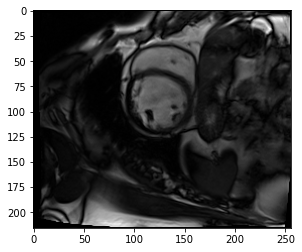

In [4]:
plt.imshow(image[...,5], cmap='gray')

Let's plot now all the components separately (note that the last component is the heart axis)

In [6]:
def rescale(img):
    return (img - img.min())/(img.max()-img.min())

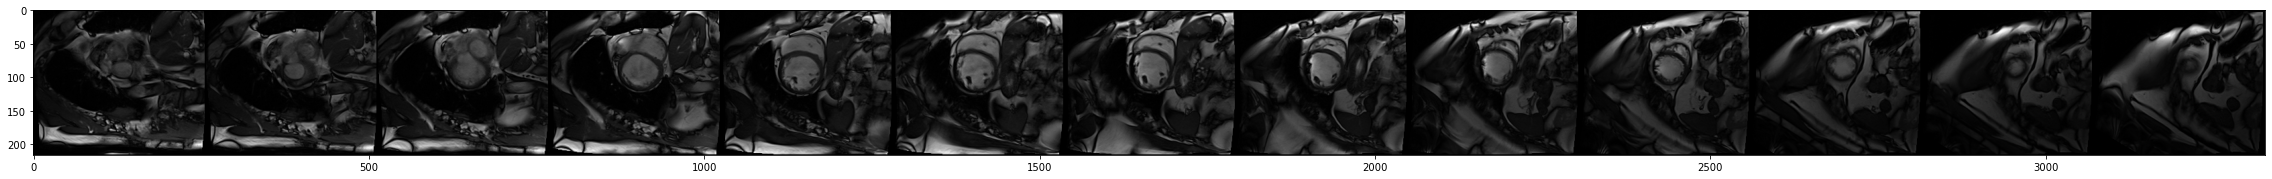

In [7]:
plt.figure(figsize=(40,16))
images = [*np.moveaxis(image,2,0)]
images = list(map(lambda x: rescale(x), images))
plt.imshow(
    np.hstack(images), cmap='gray')
plt.show()

You can see how the shape is changing for each of the components of the image. Note that we are slicing the third axis of the matrix `image`. Each image corresponds to a plane that is slicing the heart at different coordinates along the heart axis.

Let's see an illustration of how the heart is sliced to obtain these images:

<img src="https://drive.google.com/uc?id=1pwmYJNWqAbkXFMkf2cddNffazG68VlO3" alt="3D model of the heart with short axis lines." width="200"/>

Also, as we saw at the beginning, this type of image is acquired for a whole heart beat:


<img src="https://upload.wikimedia.org/wikipedia/commons/7/7f/LVSA.gif" alt="Short axis view on cardiovascular magnetic resonance imaging using a steady-state free precession imaging technique." width="130"/>

However, to keep the size of the dataset small and avoid cumbersome processing steps, I have only added the frames that are commonly used in the clinic: the _end-diastolic (ED)_ and _end-systolic (ES)_ phases. These are the phases that are manually annotated and the relevant biomarkers are derived from these annotations.

As an example, these are the two phases for the subject `A0S9V9`:

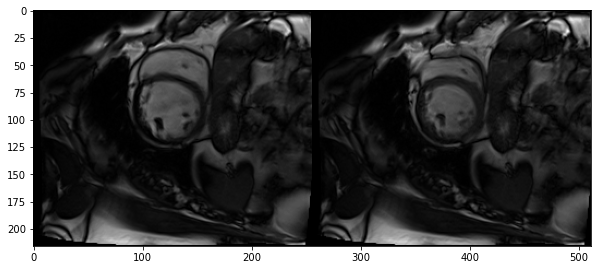

In [8]:
ed_im = nib.load(f'{PATH_TO_DATA}/mnms_nifti/training/A0S9V9/A0S9V9_sa_ED.nii.gz').get_fdata()[...,5]
es_im = nib.load(f'{PATH_TO_DATA}/mnms_nifti/training/A0S9V9/A0S9V9_sa_ES.nii.gz').get_fdata()[...,5]
plt.figure(figsize=(10,6))
plt.imshow(np.hstack((ed_im, es_im)), cmap='gray')
plt.show()

You can see that the body surrounding the heart is mostly fixed, while the heart muscle (black circumference) and the two bright cavities (left and rigth ventricles) shrink.

### What are the delineations then?

Let's visualize them separately as well. The colors correspond to _Left Ventricle_ (darker gray), _Myocardium_ (light gray) and _Right Ventricle_ (white).

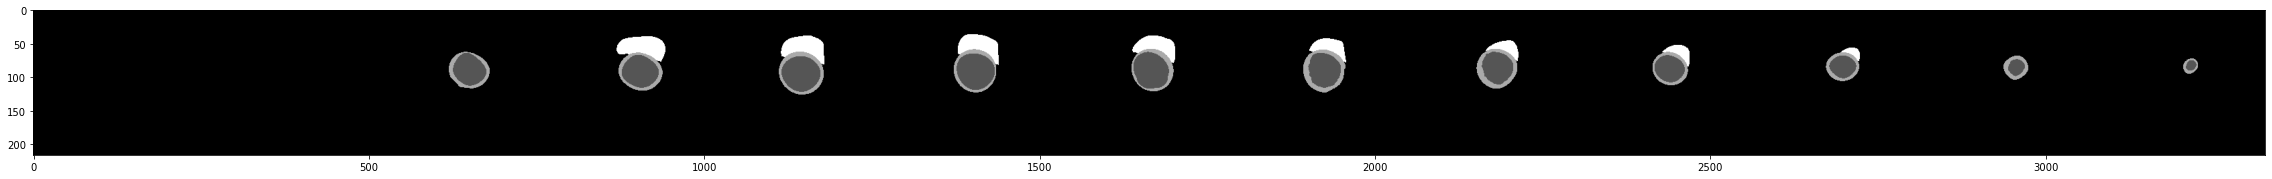

In [9]:
nii_file = nib.load(f'{PATH_TO_DATA}/mnms_nifti/training/A0S9V9/A0S9V9_sa_ED_gt.nii.gz')
delin = nii_file.get_fdata()
plt.figure(figsize=(40,16))
plt.imshow(
    np.hstack([*np.moveaxis(delin,2,0)]), cmap='gray')
plt.show()

We can combine image and annotation to crop the heart from the image:

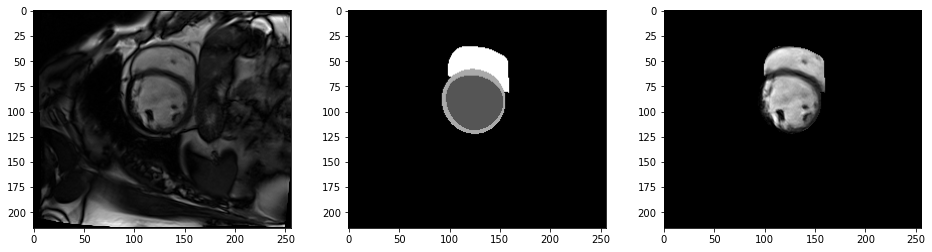

In [10]:
z = 5 # Choose the 5th component again, as an example

f, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].imshow(image[...,z], cmap='gray')
axs[1].imshow(delin[...,z], cmap='gray')
axs[2].imshow(image[...,z] * np.clip(delin[...,z], 0, 1), cmap='gray')

plt.show()

or plot the delineation over the image:

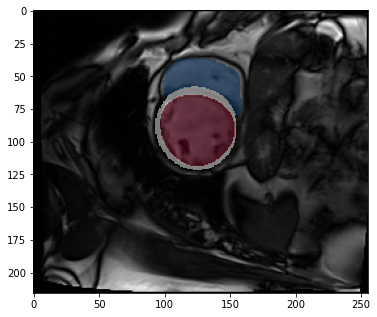

In [11]:
z = 5

plt.figure(figsize=(6,6))
plt.imshow(image[...,z], cmap='gray')
masked = np.ma.masked_where((delin[...,z] == 0), delin[...,z])
plt.imshow(masked, cmap='RdBu', alpha=0.5)

plt.show()

---
### What is the next step?

Now that we understand the data, we would like to build a model that can predict the annotation given an input image.

<img src="https://drive.google.com/uc?id=1NRJv9Ty5j4m7JohzNSIB91M2j5SgzEVN" alt="Model depiction." width="600"/>

For doing this, we need to build the model block in the illustration and also learn _how to train it_. But first, let's prepare the data so that we can work more easily later.

---
# Data preparation

If you have understood the previous content, you should know now that nifti images have a 3D shape that consists of _a stack of 2D images_. This is not convenient for model training, since we will be passing images separately and not as a stack (you can also pass the whole stack if you build a 3D model, but we won't cover it in this course).

So, we want to save the 2D images as independent files and also in another format that is much more convenient and widespread: PNG.

To do so, we need to rescale the image intensities to the range [0,255] (in nifti files the intensities can have any range). The mask values, however, are integers {0,1,2,3} and we don't need to alter them.

We'll use the `rescale` function and `opencv` to save the new files.

In [18]:
import cv2

In [41]:
def rescale(im, _min=0, _max=1):
    '''
    Rescale the input image intensities to a given range [_min, _max]
    '''
    assert _max > 0, 'Max value must be greater than 0.'
    assert type(im) == np.ndarray, 'Pass image as a numpy array.'

    return _max * (im - im.min() + _min) / (im.max() - im.min())

This is an example with the `A0S9V9` subject. I have processed all the other files already and they are in the `mnms_png` folder.

In [53]:
nii_image = nib.load(f'{PATH_TO_DATA}/mnms_nifti/training/A0S9V9/A0S9V9_sa_ED.nii.gz').get_fdata()
mk_image = nib.load(f'{PATH_TO_DATA}/mnms_nifti/training/A0S9V9/A0S9V9_sa_ED_gt.nii.gz').get_fdata()

# We iterate over the heart axis (last axis)
nii_image = rescale(nii_image, 0, 255).astype(int)
for z in range(nii_image.shape[-1]):
    im = nii_image[...,z]
    mk = mk_image[...,z]
    cv2.imwrite('{}/mnms_png/training/A0S9V9/A0S9V9_sa_ED_z{:02d}.png'.format(PATH_TO_DATA, z), im)
    cv2.imwrite('{}/mnms_png/training/A0S9V9/A0S9V9_sa_ED_z{:02d}_gt.png'.format(PATH_TO_DATA, z), mk)

---
# Other characteristics

A final consideration about the dataset. The M&Ms dataset is a collection of scans from different centres that use scanners from different manufacturers. This makes it a diverse dataset and especially interesting for assessing the generalizability of models from one vendor to another.

There is a csv file available with the imaging data that contains this information:

In [20]:
import pandas as pd

In [21]:
info = pd.read_csv(f'{PATH_TO_DATA}/mnms_info.csv')

There are 75, 50 and 25 studies from centers 1,2 and 3, respectively, for training and up to 136 studies for testing from all centers.

In [22]:
info.groupby(['Centre', 'Vendor']).count()

,,External code,VendorName,ED,ES,Age,Pathology,Sex,Height,Weight,Training
Centre,Vendor,,,,,,,,,,
1,A,91,91,91,91,91,91,91,81,91,75
2,B,69,69,69,69,69,69,69,0,69,50
3,B,46,46,46,46,46,46,46,0,46,25
4,C,40,40,40,40,40,40,40,0,40,0
5,D,40,40,40,40,40,40,40,40,38,0


In [23]:
info.head()

,External code,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight,Training
0,A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0,x
1,A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0,x
2,A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0,x
3,A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0,x
4,A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN,NaN


---

In [46]:
def pad_and_crop(orig_im):
    # Pad image to make it square
    orig_im = orig_im[...,0]
    x,y = orig_im.shape[:2]
    diff_y = np.clip(x - y, 0, 100)
    diff_x = np.clip(y - x, 0, 100)
    
    newim = np.pad(orig_im, ((diff_x//2, diff_x//2), (diff_y//2, diff_y//2)), mode='constant', constant_values=0)
    
    # Crop image to 80% of the original size
    s = newim.shape[0]
    c = int(0.8*s)
    diff = (s-c)//2
    cropim = newim[diff:-diff,diff:-diff]
    
    return cropim

**Task 1**: use the examples provided above to visualize the stack of images of four subjects from four different centers.

In [47]:
import glob

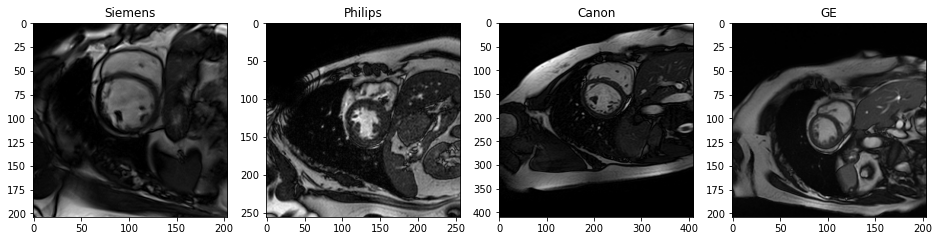

In [55]:
# IDs from 4 centers (array with code and vendor name)
_filt = info.drop_duplicates(subset='VendorName')[['External code', 'VendorName']].values

ims = []
for _id, n in _filt:
    # Find filename
    f = list(glob.iglob(f'{PATH_TO_DATA}/mnms_png/*/{_id}/{_id}_sa_ED_z05.png'))[0]
    # Load image
    im = cv2.imread(f)
    # Crop to squared image
    im = pad_and_crop(im)
    # Save image and vendor name
    ims.append([im, n])

fig, axs = plt.subplots(1,4,figsize=(16,4))
for idx, (i,n) in enumerate(ims):
    axs[idx].imshow(i, cmap='gray'); axs[idx].set_title(n)
plt.show()

You can visualize the same changing the z coordinate to different values to observe how the heart looks for the different slices.

**Task 2**: use the examples provided above to visualize different patients that were scanned with the same machine.

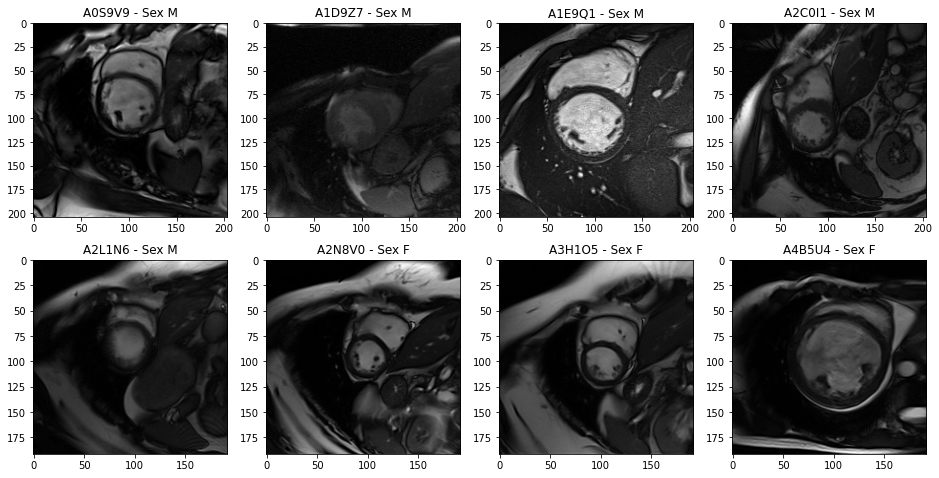

In [64]:
# IDs from 4 centers (array with code and vendor name)
subset = info[(info.VendorName == 'Siemens')&(info.Centre==1)]
_filt = subset[['External code', 'Sex']].values[:8]

ims = []
for _id, sex in _filt:
    # Find filename
    f = list(glob.iglob(f'{PATH_TO_DATA}/mnms_png/*/{_id}/{_id}_sa_ED_z05.png'))[0]
    # Load image
    im = cv2.imread(f)
    # Crop to squared image
    im = pad_and_crop(im)
    # Save image and vendor name
    ims.append([im, _id, sex])

fig, axs = plt.subplots(2,4,figsize=(16,8))
for idx, (i,n,s) in enumerate(ims):
    axs[idx//4,idx%4].imshow(i, cmap='gray')
    axs[idx//4,idx%4].set_title(f'{n} - Sex {s}')
plt.show()

**Task 3**: use the examples provided above to visualize different patients (compare two pathologies and compare a man and a woman) that were scanned with the same machine.

Note that we are visualizing 4 different patients with different pathologies (one of them is "healthy" - NOR). Can you see differences in the heart morphology?

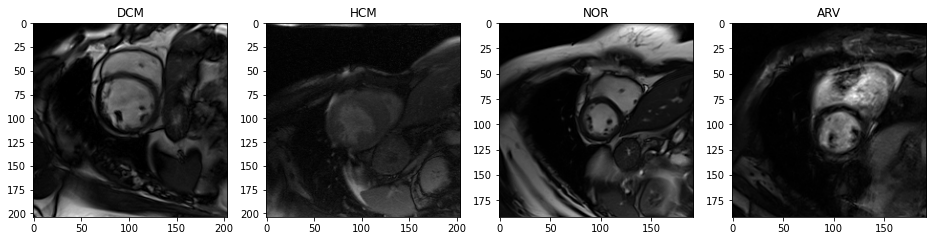

In [57]:
# IDs from 4 centers (array with code and vendor name)
subset = info[info.VendorName == 'Siemens']
_filt = subset.drop_duplicates('Pathology')[['External code', 'Pathology']].values

ims = []
for _id, n in _filt:
    # Find filename
    f = list(glob.iglob(f'{PATH_TO_DATA}/mnms_png/*/{_id}/{_id}_sa_ED_z05.png'))[0]
    # Load image
    im = cv2.imread(f)
    # Crop to squared image
    im = pad_and_crop(im)
    # Save image and vendor name
    ims.append([im, n])

fig, axs = plt.subplots(1,4,figsize=(16,4))
for idx, (i,n) in enumerate(ims):
    axs[idx].imshow(i, cmap='gray'); axs[idx].set_title(n)
plt.show()